In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils import HopfieldEnergy, HopfieldUpdate
from torch.utils.data import Subset, DataLoader
import argparse
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torchvision
import torchvision.transforms as transforms
import numpy as np
import csv
import os
import time
from tabulate import tabulate

In [6]:
# Parameters

input_size = 784
hidden1_size = 256
hidden2_size = 256
output_size = 11
free_steps = 40
nudge_steps = 5
learning_rate = 1.0
beta = 1.0
# batch_dim = 5
batch_size = 5
n_iters = 4000
mr = 0.5
lam = 1.0
print_frequency = 25
n_epochs = 20
n_steps=10000



In [7]:
def minimizeEnergy(model,steps,optimizer,x,h1,h2,y,target=None,beta=None,print_energy=False):
    energies = []  # List to store the energy values
    for step in range(steps):
        optimizer.zero_grad()
        energy = model(x, h1, h2, y, target=target,beta=beta)
        energy.backward()
        optimizer.step()

        # Restrict values between 0 and 1
        h1.data = torch.clamp(h1.data, 0, 1)
        h2.data = torch.clamp(h2.data, 0, 1)
        y.data = torch.clamp(y.data, 0, 1)

        energies.append(energy.item())  # Save the energy value

    # Save copy of the internal state variables
    h1_free = h1.detach().clone()
    h2_free = h2.detach().clone()
    y_free = y.detach().clone()

    return h1_free, h2_free, y_free, energies

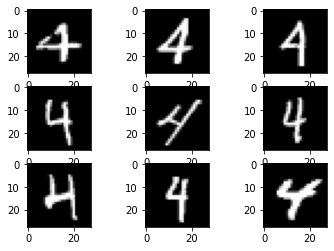

In [8]:
# Data

images = torch.rand(3, input_size)
states = torch.eye(output_size)


# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.view(-1))])
trainset = torchvision.datasets.MNIST(root='~/datasets', train=True, download=True, transform=transform)

indices = [[] for label in range(10)]
for idx, target in enumerate(trainset.targets):
    indices[target].append(idx)

trainloader = [iter(DataLoader(Subset(trainset,indices[label]), batch_size=batch_size, shuffle=True, num_workers=2)) for label in range(10)]

# Plot samples
plt.figure()
for idx,(image,label) in enumerate(trainloader[4]):
    if idx==9:
        break
    plt.subplot(3,3,idx+1)
    plt.imshow(image[0].reshape(28,28).numpy(), cmap=cm.gray)
plt.show()




#### Experiment 1 ####

Description:

1) Clamp first image and let settle 40 steps
2) Clamp intermediate label of image for relevant half of the output layer. Mask the rest. Let settle 5 steps. Intermediate label consists of 1-hot in the "intermediate half" of the target, and 0's in the "final half".
3) EP update
4) Clamp second image and let settle for 40 steps (output free)
5) Clamp final label on second half of output layer. Mask the other half. Settle for 5 steps
6) EP update

#### Experiment 2 ####

Description:

1) Clamp first image and let settle 40 steps (e.g. image #2 )
2) Clamp intermediate label of image 1 and let settle 5 steps. Intermediate label consists of 1-hot in the "intermediate half" of the target, and 0's in the "final half". 
3) EP update
4) Clamp second image and let settle for 40 steps (output free)
5) Clamp final label, which is a 2-hot with the intermediate label spot AND final label spot as ones. Settle for 5 steps
6) EP update




In [9]:
output_size = 12

# Define the model
model = HopfieldEnergy(input_size, hidden1_size, hidden2_size, output_size, beta=beta, lam=lam)

# Labels
intermediate_labels = torch.zeros(3,output_size)
for i in range(3):
    intermediate_labels[i,i] = 1

final_labels = torch.zeros(3,3,output_size)
for i in range(3):
    for j in range(3):
        final_labels[i,j,i] = 1
        final_labels[i,j,3+3*i+2] = 1

# Initialize the internal state variables
x = torch.zeros(batch_size,input_size)
h1 = torch.zeros(batch_size, hidden1_size, requires_grad=True)
h2 = torch.zeros(batch_size, hidden2_size, requires_grad=True)
y = torch.zeros(batch_size, output_size, requires_grad=True)
optimizer = optim.SGD([h1, h2, y], lr=mr)

###############
# Training loop
###############

lr1 = 0.005

for itr in range(n_steps):
    w1_update, w2_update, w3_update, b1_update, b2_update, b3_update = [], [], [], [], [], []

    # Pick which input to use as the trigger
    i = itr%3

    # Phase 1 learning
    # x.data = images[i:i+1].clone().detach()
    x.data, label = next(trainloader[i]) # get MNIST image from class i

    # Zero out state variables
    h1.data.zero_()
    h2.data.zero_()
    y.data.zero_()
    
    # target = states[i:i+1].clone().detach()
    target = torch.tile(intermediate_labels[i],(batch_size,1)).clone().detach()

    # Find where state currently settles to. Nudge towards target
    h1_free, h2_free, y_free, energies = minimizeEnergy(model,40,optimizer,x,h1,h2,y,print_energy=False)
    w1_update.append(x.t()@h1_free)
    w2_update.append(h1_free.t()@h2_free)
    w3_update.append(h2_free.t()@y_free)
    b1_update.append(h1_free.sum(0))
    b2_update.append(h2_free.sum(0))
    b3_update.append(y_free.sum(0))

    if itr%100==0:
        print("i: ",i)
        print("target: ",target.detach().numpy())
        print("y_free: ",y_free.detach().numpy())
        print("")

    beta = 1.0*torch.ones(1,output_size)
    # beta = torch.zeros(1,output_size)
    # beta[:,:3] = 0.5
    h1_nudge, h2_nudge, y_nudge, energies2 = minimizeEnergy(model,5,optimizer,x,h1,h2,y,target=target,beta=beta,print_energy=False)
    w1_update.append(x.t()@h1_nudge)
    w2_update.append(h1_nudge.t()@h2_nudge)
    w3_update.append(h2_nudge.t()@y_nudge)
    b1_update.append(h1_nudge.sum(0))
    b2_update.append(h2_nudge.sum(0))
    b3_update.append(y_nudge.sum(0))

    # Get total update
    w1_update = lr1*(-w1_update[0] + w1_update[1]) 
    w2_update = lr1*(-w2_update[0] + w2_update[1]) 
    w3_update = lr1*(-w3_update[0] + w3_update[1]) 
    b1_update = lr1*(-b1_update[0] + b1_update[1]) 
    b2_update = lr1*(-b2_update[0] + b2_update[1]) 
    b3_update = lr1*(-b3_update[0] + b3_update[1]) 

    # Update the weights
    model.w1.weight.data += w1_update
    model.w2.weight.data += w2_update
    model.w3.weight.data += w3_update
    model.b1.weight.data += b1_update
    model.b2.weight.data += b2_update
    model.b3.weight.data += b3_update

    # Phase 2 learning
    if itr>5000: # Start phase 2 learning
        assert(0)
        lr1,lr2 = 0.002,0.005

        w1_update, w2_update, w3_update, b1_update, b2_update, b3_update = [], [], [], [], [], []
        # Get second image index
        if i==0:
            j = np.random.choice([1,2])
        elif i==1:
            j = np.random.choice([0,2])
        else:
            j = np.random.choice([0,1])


        # x.data = images[j:j+1].clone().detach() # Set new images
        x.data = next(trainloader[j])[0].clone().detach()
    
        # Experiment: try continuing to learn intermediate label down phase 2
        # target = states[k:k+1].clone().detach() # Set new target
        # target = (states[k:k+1]+states[i:i+1]).clone().detach() # Set new target
        target = final_labels[i,j].clone().detach()

        # Find where state currently settles to previous state
        h1_free, h2_free, y_free, energies = minimizeEnergy(model,40,optimizer,x,h1,h2,y,print_energy=False)
        w1_update.append(x.t()@h1_free)
        w2_update.append(h1_free.t()@h2_free)
        w3_update.append(h2_free.t()@y_free)
        b1_update.append(h1_free.sum(0))
        b2_update.append(h2_free.sum(0))
        b3_update.append(y_free.sum(0))

        # Experiment: try continuing to learn intermediate label down phase 2
        beta = 0.5*torch.ones(1,output_size)
        # beta = torch.zeros(1,output_size)
        # beta[:,3:] = 0.5
  
        h1_nudge, h2_nudge, y_nudge, energies2 = minimizeEnergy(model,5,optimizer,x,h1,h2,y,target=target,beta=beta,print_energy=False)
        w1_update.append(x.t()@h1_nudge)
        w2_update.append(h1_nudge.t()@h2_nudge)
        w3_update.append(h2_nudge.t()@y_nudge)
        b1_update.append(h1_nudge.sum(0))
        b2_update.append(h2_nudge.sum(0))
        b3_update.append(y_nudge.sum(0))

        if itr%100==0:
            print("i,j: ",i,j)    
            print("Target: ",target.detach().numpy())
            print("y: ",y_nudge.detach().numpy())
            print("")

        w1_update = lr2*(-w1_update[0] + w1_update[1]) 
        w2_update = lr2*(-w2_update[0] + w2_update[1])
        w3_update = lr2*(-w3_update[0] + w3_update[1]) 
        b1_update = lr2*(-b1_update[0] + b1_update[1]) 
        b2_update = lr2*(-b2_update[0] + b2_update[1]) 
        b3_update = lr2*(-b3_update[0] + b3_update[1]) 

        # Update the weights
        model.w1.weight.data += w1_update
        model.w2.weight.data += w2_update
        model.w3.weight.data += w3_update
        model.b1.weight.data += b1_update
        model.b2.weight.data += b2_update
        model.b3.weight.data += b3_update

    # if itr%10 == 0:

    #     print("Iteration: ", itr)
    #     print("================================================================")

    #     for i in range(3):

    #         if itr>600:
    #             print("\nPhase 2 errors")

    #             # x.data = images[i:i+1].clone().detach()
    #             x.data = next(trainloader[i])[0].clone().detach()

    #             h1.data.zero_()
    #             h2.data.zero_()
    #             y.data = torch.zeros(1,output_size)
    #             h1_free, h2_free, y_free, energies = minimizeEnergy(model,40,optimizer,x,h1,h2,y,print_energy=False)
                
    #             # Get second image index
    #             if i==0:
    #                 j = np.random.choice([1,2])
    #             elif i==1:
    #                 j = np.random.choice([0,2])
    #             else:
    #                 j = np.random.choice([0,1])


    #             # x.data = images[j:j+1].clone().detach() # Set new images
    #             x.data = next(trainloader[j])[0].clone().detach()

    #             h1_free, h2_free, y_free, energies = minimizeEnergy(model,40,optimizer,x,h1,h2,y,print_energy=False)
                
    #             # target = states[k:k+1].clone().detach() # Set new target
    #             target = final_labels[i,j].clone().detach()
  
            #     print("i=",i,",j=",j)
            #     print("Stage 2: ",y_free.detach().numpy())
            #     print("")

            # if itr>400:
            #     print("\nPhase 1 errors")

            #     # x.data = images[i:i+1].clone().detach()
            #     x.data = next(trainloader[i])[0].clone().detach()

            #     h1.data.zero_()
            #     h2.data.zero_()
            #     y.data = torch.zeros(1,output_size)
            #     # target = states[i:i+1].clone().detach()
            #     target = intermediate_labels[i].clone().detach()
            #     h1_free, h2_free, y_free, energies = minimizeEnergy(model,20,optimizer,x,h1,h2,y,print_energy=False)

            #     print("i=",i)
            #     print("Stage 1: ",y_free.detach().numpy())
            #     print("\n")

            # # if itr>800:
            # #     assert(0)











i:  0
target:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
y_free:  [[0.         0.         0.         0.         0.         0.2591869
  0.05814953 0.         0.34554964 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.2716682
  0.07004391 0.         0.29989076 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.210349
  0.12865855 0.         0.3407193  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.27998638
  0.07403888 0.         0.38272488 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.28824663
  0.11826628 0.         0.30421907 0.         0.         0.        ]]

i:  1
target:  [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0.